# Sentiment Analysis with Deep Learning using BERT

Welcome to the Sentiment Analysis with Deep Learning using BERT project!
This Cousera hands-on project is designed to help you master the key skills needed to build a powerful text classification model using BERT (Bidirectional Encoder Representations from Transformers). By the end of this project, you’ll have the expertise to fine-tune a pre-trained BERT model to classify tweets based on emotional content, detecting sentiments such as happiness, sadness, anger, disgust, and surprise with high accuracy.

### Prerequisites

- Intermediate-level knowledge of Python 3 (NumPy and Pandas preferably, but not required)
- Exposure to PyTorch usage
- Basic understanding of Deep Learning and Language Models (BERT specifically)

### Project Outline

**Task 1**: Introduction (this section)

**Task 2**: Exploratory Data Analysis and Preprocessing

**Task 3**: Training/Validation Split

**Task 4**: Loading Tokenizer and Encoding our Data

**Task 5**: Setting up BERT Pretrained Model

**Task 6**: Creating Data Loaders

**Task 7**: Setting Up Optimizer and Scheduler

**Task 8**: Defining our Performance Metrics

**Task 9**: Creating our Training Loop

**Task 10**: Loading and Evaluating our Model

## Task 1: Introduction

### What is BERT?
BERT (Bidirectional Encoder Representations from Transformers) is a large-scale, transformer-based language model developed by Google. It revolutionized natural language processing (NLP) by introducing bidirectional context understanding, which allows the model to grasp the meaning of a word based on both the words that come before and after it in a sentence. This makes BERT exceptionally powerful for various NLP tasks, such as sentiment analysis, question answering, and text classification.

BERT can be fine-tuned for specific downstream tasks like emotion classification, as done in this project.

For more information:

Check out the original BERT paper.[here](https://arxiv.org/abs/1810.04805). 

Dive into the Hugging Face BERT documentation. [HuggingFace documentation](https://huggingface.co/transformers/model_doc/bert.html)



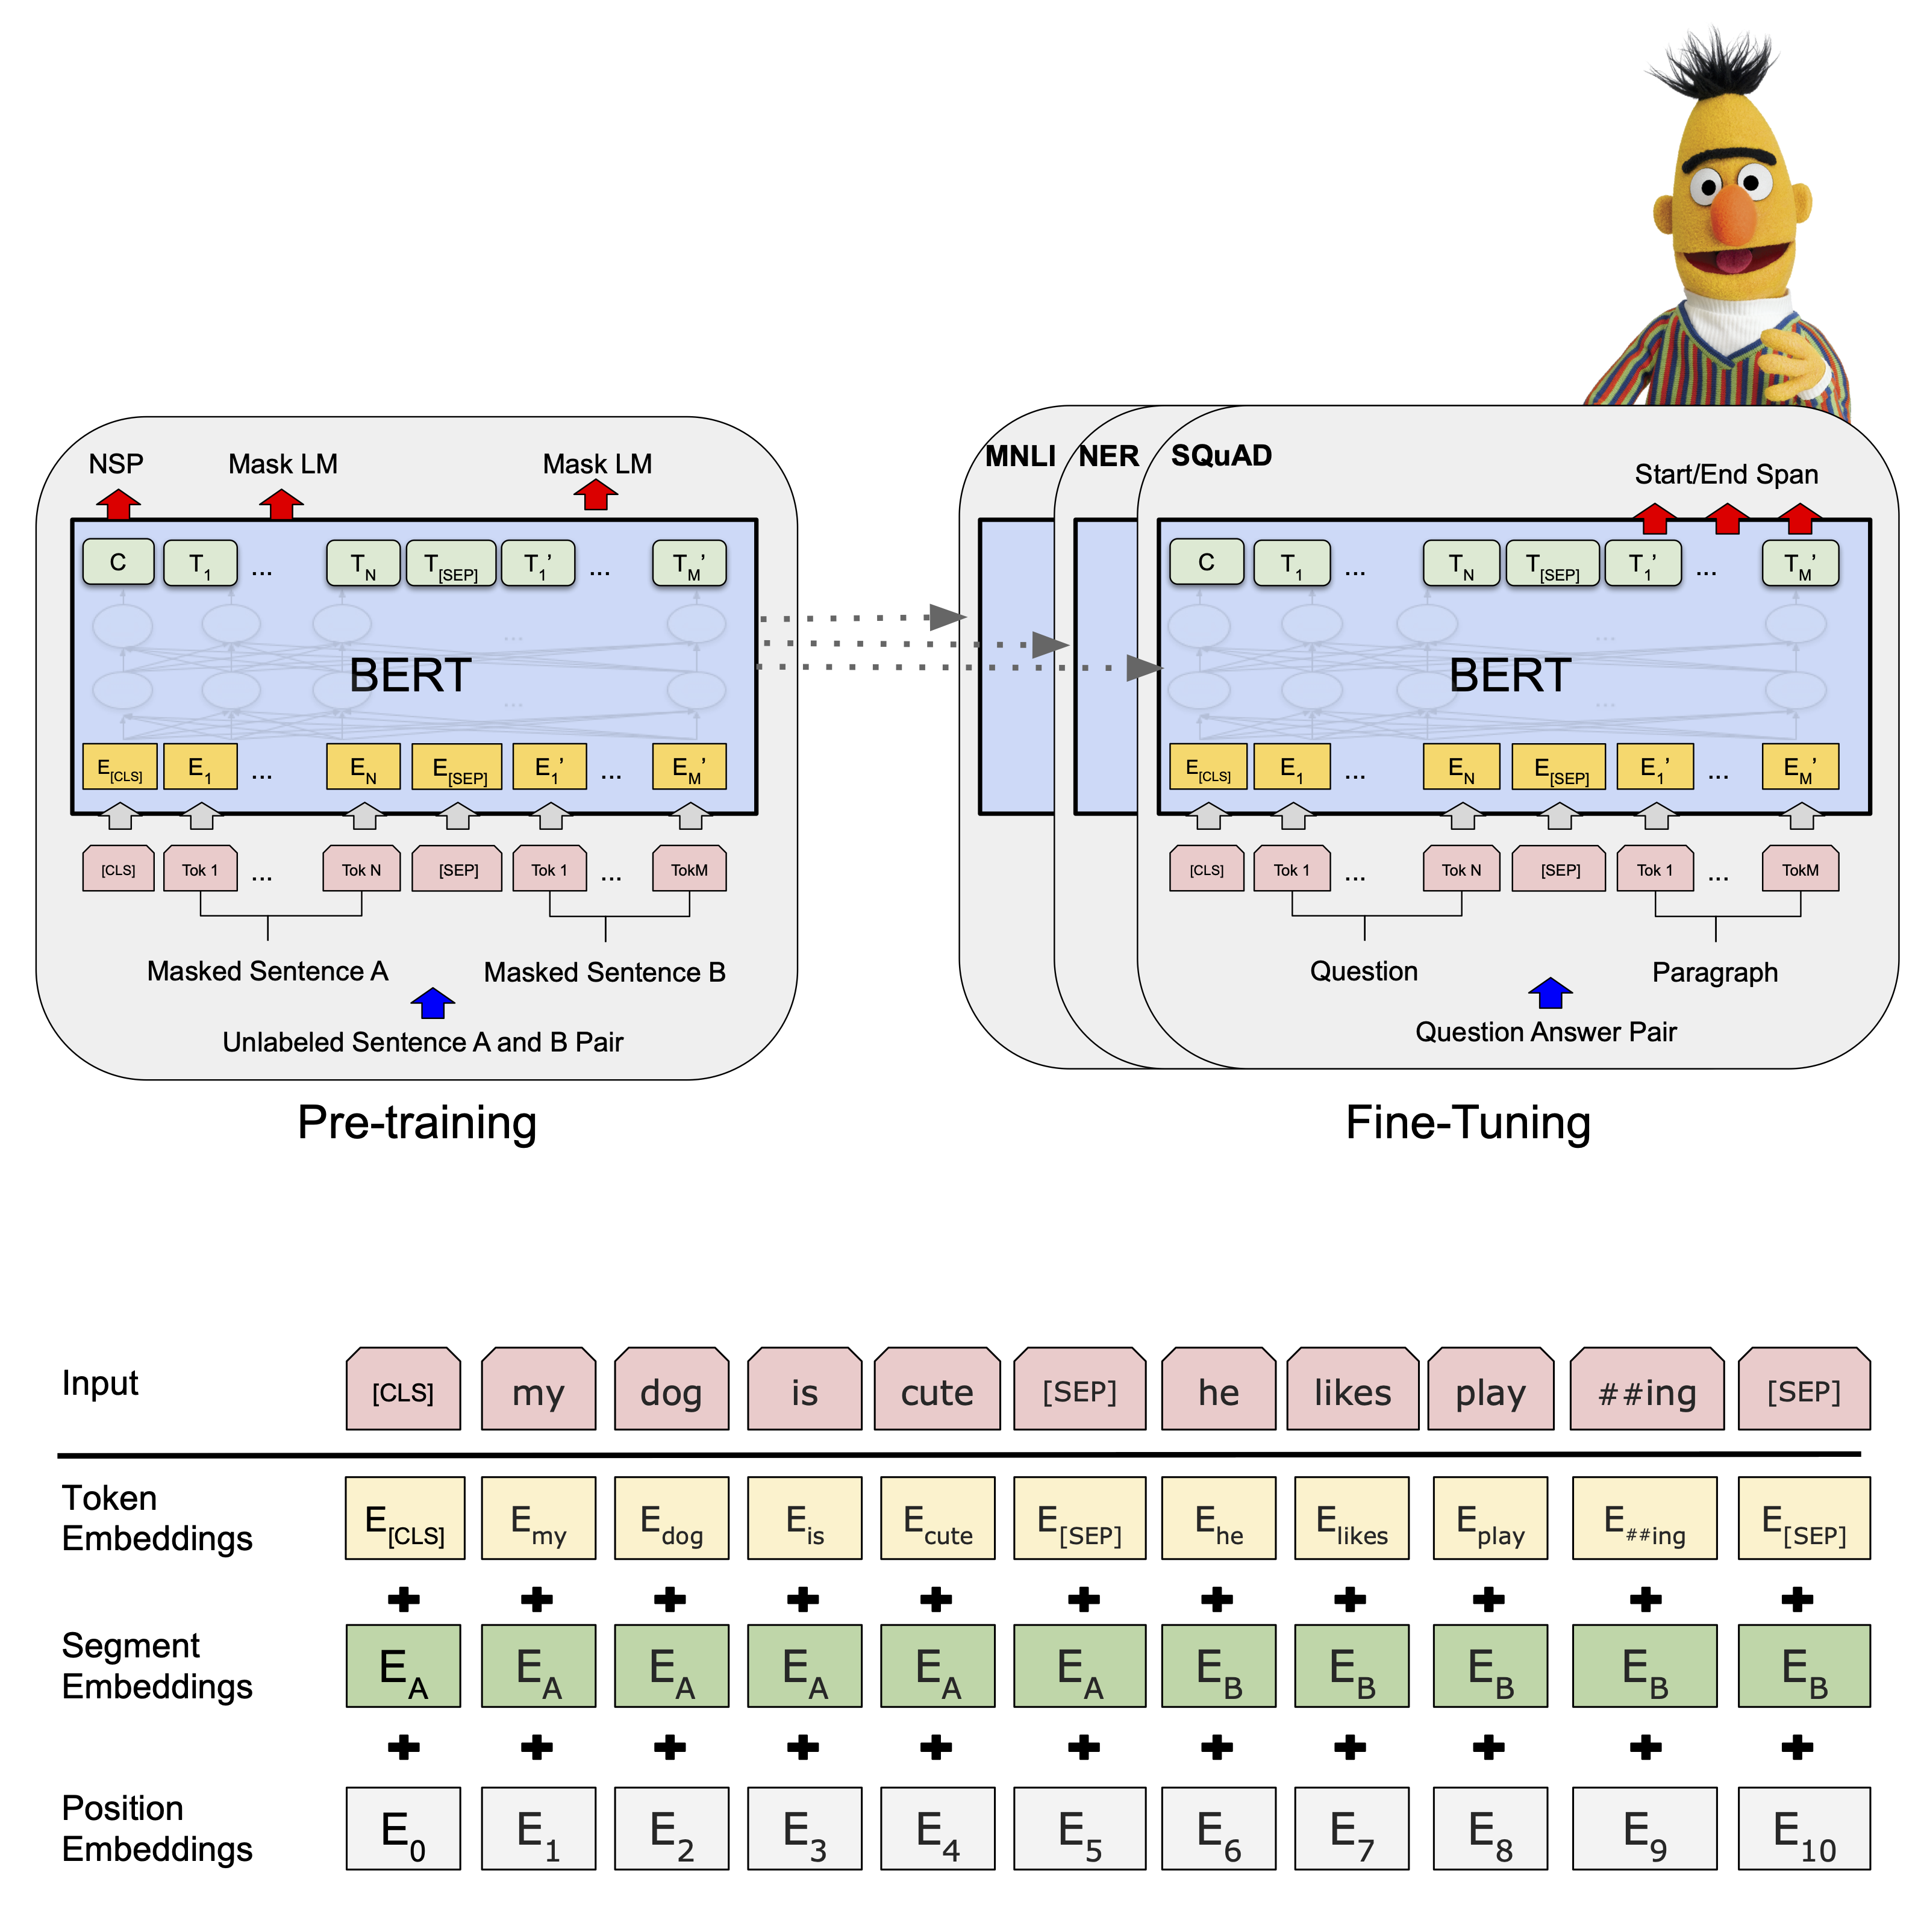

### Dataset Description
We utilized the SMILE Twitter Emotion Dataset, which was collected and annotated for the SMILE Project. This dataset consists of tweets mentioning 13 Twitter handles associated with British museums, gathered between May 2013 and June 2015. The primary goal of this dataset is to classify emotions expressed on Twitter towards arts and cultural experiences in museums.

It contains 3,085 tweets, with 5 emotions namely anger, disgust, happiness, surprise and sadness

Citation:
Wang, Bo; Tsakalidis, Adam; Liakata, Maria; Zubiaga, Arkaitz; Procter, Rob; Jensen, Eric (2016): SMILE Twitter Emotion dataset. Figshare. Dataset. https://doi.org/10.6084/m9.figshare.3187909.v2

## Task 2: Exploratory Data Analysis and Preprocessing

In [1]:
import torch  # For building and training deep learning models (modeling section of the project)
import pandas as pd  # For loading and manipulating the dataset
from tqdm.notebook import tqdm  # Displays progress bars to track loops, especially useful during model training

In [2]:
# Load the dataset from a CSV file into a pandas DataFrame
df = pd.read_csv(
    'Data/smile-annotations-final.csv',
    names=['id', 'text', 'category']  # Set column names: 'id' (unique identifier), 'text' (the tweet), 'category' (the sentiment/emotion)
)

# Set 'id' as the index since it's unique for each row, making it easier to navigate the DataFrame
df.set_index('id', inplace=True) # Modifies 'df' directly without needing reassignment


In [3]:
df.head() # Returns the first 5 rows   

,text,category
id,,
611857364396965889,@aandraous @britishmuseum @AndrewsAntonio Merc...,nocode
614484565059596288,Dorian Gray with Rainbow Scarf #LoveWins (from...,happy
614746522043973632,@SelectShowcase @Tate_StIves ... Replace with ...,happy
614877582664835073,@Sofabsports thank you for following me back. ...,happy
611932373039644672,@britishmuseum @TudorHistory What a beautiful ...,happy


In [4]:
df.text.iloc[0] # Access the first tweet (text) in the 'text' column using iloc

'@aandraous @britishmuseum @AndrewsAntonio Merci pour le partage! @openwinemap'

In [5]:
# Count the occurrences of each unique category (emotion) in the 'category' column
df.category.value_counts()

# This is useful to check class imbalance, as value_counts shows how many times each emotion appears in the data.
# 'nocode' represents no clear emotion, so we ignore it; 
# The same logic can apply to 'not relevant', but we keep it as an emotion in this case.
# Tweets with multiple emotions are not supported because it would be hard to train BERT for this multi-label scenario.
# We prefer each tweet to have one emotion (one-hot encoded output), which helps BERT classify a single emotion.


nocode               1572
happy                1137
not-relevant          214
angry                  57
surprise               35
sad                    32
happy|surprise         11
happy|sad               9
disgust|angry           7
disgust                 6
sad|disgust             2
sad|angry               2
sad|disgust|angry       1
Name: category, dtype: int64

In [6]:
# Filter out rows where the 'category' column contains multiple emotions (indicated by '|')
df = df[~df.category.str.contains('\|')]
# The backslash (\) is escaping the | symbol because it's a special character in regular expressions.
# ~ (The tilde) is the logical NOT operator. So, ~df.category.str.contains('\|') means "select rows where the category does NOT contain a | symbol".

In [7]:
# Remove rows where the 'category' is labeled as 'nocode' (no clear emotion)
df = df[df.category != 'nocode']

In [8]:
# Check the distribution of each category (emotion) in the dataset
df.category.value_counts()  # Shows class imbalance with a big discrepancy in the number of instances per category

happy           1137
not-relevant     214
angry             57
surprise          35
sad               32
disgust            6
Name: category, dtype: int64

In [9]:
# Get all unique categories (emotions) present in the 'category' column
possible_labels = df.category.unique()

In [10]:
# Create an empty dictionary to store labels and their corresponding index values
label_dict = {}

# Loop over the possible labels and assign each one a unique index
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index  # Map each label to a unique index (starting from 0)

# Output the dictionary that shows labels mapped to indices
label_dict

{'happy': 0,
 'not-relevant': 1,
 'angry': 2,
 'disgust': 3,
 'sad': 4,
 'surprise': 5}

In [11]:
# Create a new 'label' column in the DataFrame by replacing categories with their corresponding numeric labels from label_dict
df['label'] = df.category.replace(label_dict)

# Display the first 10 rows to verify the new 'label' column
df.head(10)

,text,category,label
id,,,
614484565059596288,Dorian Gray with Rainbow Scarf #LoveWins (from...,happy,0
614746522043973632,@SelectShowcase @Tate_StIves ... Replace with ...,happy,0
614877582664835073,@Sofabsports thank you for following me back. ...,happy,0
611932373039644672,@britishmuseum @TudorHistory What a beautiful ...,happy,0
611570404268883969,@NationalGallery @ThePoldarkian I have always ...,happy,0
614499696015503361,Lucky @FitzMuseum_UK! Good luck @MirandaStearn...,happy,0
613601881441570816,Yr 9 art students are off to the @britishmuseu...,happy,0
613696526297210880,@RAMMuseum Please vote for us as @sainsbury #s...,not-relevant,1
610746718641102848,#AskTheGallery Have you got plans to privatise...,not-relevant,1


## Task 3: Training/Validation Split


### Class Imbalance Issue:

In our dataset, 'happy' has the most samples (1137), while 'disgust' has the least (6). Emotions like 'angry', 'sad', and 'surprise' have roughly the same number of samples.

### Why This Is a Problem for Splitting the Data:

If we use a standard 70-30 split (70% for training, 30% for testing) without considering the class distribution, some emotions—especially rare ones like 'disgust'—might not appear in both the training and validation sets.
This is a Two-Fold Problem:

1. Validation Set Issue:
If 'disgust' isn’t in the validation set, we can’t evaluate how well the model predicts this emotion.

2. Training Set Issue (more serious):
If 'disgust' isn’t in the training set, the model will never learn what 'disgust' looks like. As a result, it will never predict 'disgust' correctly during testing.

To ensure all classes are properly represented in both the training and validation sets, we can use a Stratified Split, a technique used to ensure that each class is proportionally represented in both the training and testing datasets.

In [12]:

from sklearn.model_selection import train_test_split  # Import train_test_split with stratified option

In [13]:
# Split the dataset into training and validation sets while maintaining class distribution

X_train, X_val, y_train, y_val = train_test_split(
    df.index.values,        # Using index to uniquely identify each sample
    df.label.values,        # Contains target labels (numeric emotions)
    test_size=0.15,         # 15% of the data will go into the validation set
    random_state=17,        # Ensures reproducibility of the split
    stratify=df.label.values  # Ensures that each class is proportionally represented
)

# Since the smallest class (disgust) has only 6 samples, using a smaller validation set ensures that more data is available for training. 
# This helps the model learn better from rare classes.  

In [14]:
# Creating a new column to track whether each sample is used for training or validation
df['data_type'] = ['not_set'] * df.shape[0]  
# This initializes the 'data_type' column with 'not_set' for all rows. We'll update this next.

In [15]:
# Marking validation samples in the DataFrame
df.loc[X_val, 'data_type'] = 'val'  
# For rows where the index is in X_val (validation set), we update 'data_type' to 'validation'.

# Marking training samples in the DataFrame
df.loc[X_train, 'data_type'] = 'train'  
# For rows where the index is in X_train (training set), we update 'data_type' to 'training'.

In [16]:
# Grouping the DataFrame by 'category', 'label', and 'data_type' and counting the occurrences in each group
df.groupby(['category', 'label', 'data_type']).count()

# - 'category' and 'label' have a 1-to-1 mapping (each category corresponds to a unique label).
# - We're using the 'groupby' function to aggregate data based on the unique combinations of 'category', 'label', and 'data_type'.
# - The 'count' function is applied to count how many rows belong to each group (which indicates the distribution of data).
# - This will give us the count of how many samples from each class (emotion) are in the training vs validation sets.
# - We can use this to check the **distribution** across different classes, ensuring that all emotions are properly represented in both training and validation sets.

text
category     label data_type      
angry        2     train        48
                   val           9
disgust      3     train         5
                   val           1
happy        0     train       966
                   val         171
not-relevant 1     train       182
                   val          32
sad          4     train        27
                   val           5
surprise     5     train        30
                   val           5

## Task 4: Loading Tokenizer and Encoding our Data

In [17]:
from transformers import BertTokenizer  
# Importing the BERT tokenizer from Hugging Face's transformers library.
# The tokenizer will convert raw text into tokens (numerical format) that the BERT model can understand.

from torch.utils.data import TensorDataset  
# Importing TensorDataset from PyTorch, which allows us to handle datasets in a PyTorch-friendly format.
# It combines input tensors (features) and target tensors (labels) into a single dataset object, 
# making it easier to load into DataLoaders for training and validation.

In [18]:
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased',    # Load the pre-trained BERT tokenizer ('bert-base-uncased').
                            # 'Uncased' means the tokenizer will treat "Happy" and "happy" as the same word.
    
    do_lower_case=True      # Convert all text to lowercase before tokenization.
                            # This ensures consistency since 'bert-base-uncased' doesn’t differentiate between uppercase and lowercase letters.
)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [19]:
# Convert all sentences (tweets) into BERT-compatible encoded form

# We use 'batch_encode_plus' to process multiple sentences at once (batch processing).
# This method tokenizes the sentences, adds special tokens ([CLS], [SEP]), and returns attention masks.

# Tokenizing and encoding the training data using BERT tokenizer
encoded_data_train = tokenizer.batch_encode_plus( 
    df[df.data_type=='train'].text.values,   # Selects the 'text' column of rows where 'data_type' is 'train'(the actual sentences)
    add_special_tokens=True,                 # Adds special tokens like [CLS] at the beginning and [SEP] at the end of the sequences
    return_attention_mask=True,              # Returns an attention mask, which tells the model where to focus and where not to (0 for padding, 1 for actual tokens)
    pad_to_max_length=True,                  # Pads all sequences to the maximum length (256 in this case)
    max_length=256,                          # Sets the maximum length of each sequence to 256 tokens
    return_tensors='pt'                      # Returns PyTorch tensors instead of lists, making it compatible with PyTorch models
)

# The validation set encoding is done in a similar way
encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].text.values, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)


# Extracting features and labels for the training set
input_ids_train = encoded_data_train['input_ids']               # Numerical token IDs representing the input text for the training set.
attention_masks_train = encoded_data_train['attention_mask']    # Attention masks for the training set to differentiate between real tokens and padding.
labels_train = torch.tensor(df[df.data_type == 'train'].label.values)  # Converts the target labels for the training set into PyTorch tensors.

# Extracting features and labels for the validation set
input_ids_val = encoded_data_val['input_ids']                  # Numerical token IDs representing the input text for the validation set.
attention_masks_val = encoded_data_val['attention_mask']       # Attention masks for the validation set.
labels_val = torch.tensor(df[df.data_type == 'val'].label.values)  # Converts the target labels for the validation set into PyTorch tensors.



Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [20]:
# Creating TensorDatasets for both training and validation data
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)  # Combines input IDs, attention masks, and labels into a single dataset for training.
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)          # Combines input IDs, attention masks, and labels into a single dataset for validation.

# TensorDataset allows us to iterate over input IDs, attention masks, and labels simultaneously in one convenient structure.

In [21]:
len(dataset_train) # Get the number of samples in the training dataset

1258

In [22]:
len(dataset_val)  # Returns the total number of samples in the validation dataset.
# This should reflect the 15% validation split, while the training dataset holds the remaining 85%.


223

In [23]:
train_percentage = (len(dataset_train) / (len(dataset_train) + len(dataset_val))) * 100
val_percentage = (len(dataset_val) / (len(dataset_train) + len(dataset_val))) * 100

print(f"Training set: {train_percentage:.2f}%")
print(f"Validation set: {val_percentage:.2f}%")

Training set: 84.94%
Validation set: 15.06%


## Task 5: Setting up BERT Pretrained Model

In [24]:
from transformers import BertForSequenceClassification  # Importing the BERT model specifically designed for sequence classification tasks.

# We treat each tweet as its own unique sequence.
# Each tweet (or sequence) will be classified into one of the six emotion categories.

In [25]:
# Redefining the BERT architecture for our specific task (sequence classification with 6 output labels)
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',  # Using the 'bert-base-uncased' model (smaller and more efficient, as compared to larger versions)
    num_labels=len(label_dict),  # Setting the number of output labels (6 classes in this case)
    output_attentions=False,  # We don't need attention scores as part of the output
    output_hidden_states=False  # We don't need the hidden states either (this is the intermediate layer output)
)

# Why 'bert-base-uncased'? It’s computationally more efficient. Larger BERT models (like 'bert-large') are more powerful but require much more compute for inference and training.
# In this case, 'bert-base-uncased' is sufficient for our task and is more practical in terms of resources.

# Since we’re fine-tuning for sequence classification, we add a classification layer on top of the pre-trained BERT model.
# BERT already understands language patterns based on its pre-training, and we’re just adjusting it to classify tweets into one of the 6 emotion categories.

# The final output of the model will be one of the 6 emotion categories (labels) based on the input tweet.


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Task 6: Creating Data Loaders

In [26]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
# DataLoader is a convenient way to batch and shuffle your dataset, allowing you to iterate over it efficiently during training and evaluation.

# RandomSampler and SequentialSampler are used to sample data in different ways for training and validation.

# RandomSampler: Used for training to randomly shuffle the data.
# Random shuffling helps the model generalize better, as it prevents the model from seeing data in a fixed order, which could lead to overfitting or bias.

# SequentialSampler is used for validation as our gradient is fixed and nothing will actually change during this phase.
# In validation, we are not updating the model's weights, so it doesn't matter whether the data is shuffled or presented in a fixed order.
# The model is just making predictions based on its already learned state and is not learning from the validation data.
# Using sequential sampling ensures consistency across different validation runs.
# If we randomly shuffled the validation data, the results might differ each time we run validation, 
# making it harder to track the model's performance reliably.
# Therefore, we use SequentialSampler to keep the validation data in the same order each time, allowing us to evaluate the model's performance in a stable, reproducible way.



In [27]:
batch_size=4  
# Setting the batch size to 4 for training due to resource limitations (memory and hardware constraints).
# The original model used a batch size of 32, but the current machine can handle only smaller batches.

# DataLoader for the training dataset
dataloader_train = DataLoader(
     dataset_train,
    sampler=RandomSampler(dataset_train),  # RandomSampler shuffles the training data, ensuring the model doesn't learn based on the order of data.
    batch_size=batch_size  # Use the smaller batch size due to hardware constraints.
)

# DataLoader for the validation dataset
dataloader_val = DataLoader(
     dataset_val,
    sampler=RandomSampler(dataset_val),  # RandomSampler for validation helps avoid any order bias.
    batch_size=32  # Since no backpropagation is involved during validation, it's safe to use a larger batch size.
)



## Task 7: Setting Up Optimizer and Scheduler

In [28]:
# Importing AdamW optimizer and learning rate scheduler from Hugging Face transformers
from transformers import AdamW, get_linear_schedule_with_warmup

# AdamW (Adam with Weight Decay) optimizer is used to adjust the weights of the model during training.
# It helps the model learn by minimizing the error between predicted and actual outputs.
# Weight decay is a regularization technique that prevents overfitting by penalizing large weights.

# The optimizer will help us tweak the weights based on the loss to improve the model's performance.


In [29]:
# Setting up the optimizer using AdamW, which is an efficient variant of the Adam optimizer with weight decay.
optimizer = AdamW(
    model.parameters(),  # This tells the optimizer which parameters (weights & biases) of the model to update.
    
    lr=1e-5,  # Learning rate: how big each update step is. 
              # The original BERT paper suggests something between 2e-5 and 5e-5, but here we're using 1e-5 for more careful updates.
    
    eps=1e-8  # Epsilon: a tiny value added to prevent division by zero errors in the optimizer's calculations.
              # It's like adding a safety net to keep the math stable.
)

# AdamW is a stochastic optimization approach:
# "Stochastic" means it updates the model's weights using small, random samples (batches) instead of the whole dataset at once.
# This randomness helps the model escape local minima (bad spots where it could get stuck) and find better solutions.


In [30]:
epochs = 10
scheduler=get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=len(dataloader_train)*epochs) # how many itterations this must go on for
    # how many times u want ur learning rate to actually change
    
# define what optimiser to use too find an approximation for our dataset
# in terms of optimising the weights to give optimal output
# set our scheduler ahich adjusts the learning rate as training goes on based on how its going    

## Task 8: Defining our Performance Metrics

Accuracy metric approach originally used in accuracy function in [this tutorial](https://mccormickml.com/2019/07/22/BERT-fine-tuning/#41-bertforsequenceclassification).

In [31]:
import numpy as np
from sklearn.metrics import f1_score

In [32]:
# Define a function to calculate the F1 score for our predictions
def f1_score_func(preds, labels):
    # preds: predicted probabilities for each class (output from the model)
    # labels: actual ground truth labels for the dataset
    
    # The output of the  model will typically be a probability distribution over the classes,
    # represented as a vector of probabilities for each of the 6 classes.
    # For example, for a single prediction, you might get a vector like:
    # [0.9, 0.05, 0.5, 0, 0, 0],
    # where each element corresponds to the probability of the tweet belonging to each of the 6 classes.
    # We want this to be a binary vector [1,0,0,0,0,0]
    
    # `np.argmax(preds, axis=1) finds the index of the max value (the predicted class) for each sample
    # axis=1 makes sure we check along rows (each row represents a single sample)
    preds_flat = np.argmax(preds, axis=1).flatten()  # Flatten the result to make sure it's a 1D array

    # Flatten the ground truth labels as well to ensure it's a 1D array as they may be coming as list of lists
    labels_flat = labels.flatten()

    return f1_score(labels_flat, preds_flat, average='weighted')
    # Calculate and return the F1 score using sklearn's f1_score function
    # `average='weighted'` ensures that the F1 score is calculated by considering class imbalances
    # It weights each class based on how many samples exist in each class.
    # - Since 'disgust' has very few samples, it's down-weighted, so the F1 score helps ensure that the model handles it well,
    #   even if it's underrepresented in the dataset.
    # We acknowledge the limitations of our dataset in its distribution of classes,
    # and the F1 score provides a better metric for assessing model performance on imbalanced datasets.

In [33]:
def accuracy_per_class(preds, labels):
    # Inverse the label dictionary for mapping numeric labels back to their text representation
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    # Flatten the predicted labels (get the class with the highest probability for each sample)
    preds_flat = np.argmax(preds, axis=1).flatten()
    # Flatten the true labels (the actual ground truth labels)
    labels_flat = labels.flatten()

    # Loop through each unique label in the labels (the classes)
    for label in np.unique(labels_flat):
        # Get the predictions for the current class
        y_preds = preds_flat[labels_flat == label]
        # Get the true labels for the current class
        y_true = labels_flat[labels_flat == label]
        
        # Print the accuracy for the current class
        print(f'Class: {label_dict_inverse[label]}')  # Convert numeric label to class name
        print(f'Accuracy: {len(y_preds[y_preds == label])}/{len(y_true)}\n')  # Calculate the number of correct predictions for this class


## Task 9: Creating our Training Loop

Approach adapted from an older version of HuggingFace's `run_glue.py` script. Accessible [here](https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128).

This script, though slightly outdated, was recommended by the Hugging Face team for fine-tuning BERT on custom datasets.


In [34]:
import random

# Setting a random seed ensures reproducibility. This means that every time you run the script, 
# you get the same results, which is important when testing, debugging, or comparing models.

# Machine learning models can behave slightly differently on each run due to random initialization 
# of weights, shuffling of data, etc. By setting a seed, we fix the randomness.

# The seed value is set to 17 here, but 42 is often used as a convention in many examples 
# You can choose any number, but sticking to one value ensures consistent results.

seed_val = 17
random.seed(seed_val)          # Sets the seed for Python's built-in random module
np.random.seed(seed_val)       # Sets the seed for NumPy's random number generator
torch.manual_seed(seed_val)    # Sets the seed for PyTorch's random number generator (CPU)

# If using a GPU-enabled machine (like Google Colab with CUDA), this ensures reproducibility 
# across all GPUs by setting the seed for CUDA operations.
torch.cuda.manual_seed_all(seed_val)  # Ensures reproducibility on GPU


In [35]:
# Check if a GPU (CUDA) is available, otherwise use the CPU.
# CUDA is a parallel computing platform that allows us to use NVIDIA GPUs to speed up deep learning computations.
# If a GPU is available, the model will be trained on it for faster performance; otherwise, it will fall back to the CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to the selected device (GPU or CPU).
# This ensures that all the model computations happen on the selected device.
model.to(device)

# Print out the device being used for clarity (useful for debugging or ensuring GPU is being utilized).
print(device)


cpu


In [36]:
def evaluate(dataloader_val):
    # Set the model to evaluation mode
    # This disables dropout layers and ensures the model behaves consistently during evaluation
    model.eval()
    
    loss_val_total = 0  # Initialize total validation loss to accumulate over batches
    predictions, true_vals = [], []  # Lists to store predicted outputs and true labels
    
    # Iterate through the validation DataLoader
    for batch in tqdm(dataloader_val):  # tqdm adds a progress bar for visual feedback
        
        # Move all batch data (input_ids, attention_masks, labels) to the correct device (GPU or CPU)
        batch = tuple(b.to(device) for b in batch)
        
        # Create a dictionary for model inputs
        inputs = {
            'input_ids': batch[0],         # The tokenized input sentences
            'attention_mask': batch[1],    # Attention mask to ignore padding tokens
            'labels': batch[2],            # True labels for the inputs
        }

        # No need to calculate gradients during evaluation, so we disable them to speed things up and save memory
        with torch.no_grad():        
            outputs = model(**inputs)  # Forward pass: Get model predictions and loss
            
        # outputs[0] is the loss, outputs[1] is the raw logits (predictions before softmax)
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()  # Accumulate the loss for later averaging

        # Move logits from GPU to CPU and convert them to NumPy arrays for further processing
        logits = logits.detach().cpu().numpy()
        # Move true labels from GPU to CPU
        label_ids = inputs['labels'].cpu().numpy()

        # Append predictions and true labels for later performance evaluation
        predictions.append(logits)
        true_vals.append(label_ids)
    
    # Calculate the average validation loss over all batches
    loss_val_avg = loss_val_total / len(dataloader_val)
    
    # Concatenate predictions and true values from all batches into single arrays
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals  # Return the average loss and predictions for further evaluation



In [37]:
for epoch in tqdm(range(1, epochs + 1)):  # Loop through the number of epochs (e.g., 10 epochs, iterating from 1 to 10)

    model.train()  # Set the model to training mode

    loss_train_total = 0  # Initialize total training loss to zero for the current epoch
    # We will accumulate the loss from each batch to compute the average training loss at the end of the epoch

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    # 'desc' shows the current epoch number on the progress bar
    # 'leave=False' makes sure the progress bar updates in-place instead of creating a new line after each epoch
    # 'disable=False' ensures the progress bar is visible; set it to True to hide the progress bar

    for batch in progress_bar:  # Loop through each batch in the training data

        model.zero_grad()  # Reset gradients to zero to avoid accumulation from previous batches

        batch = tuple(b.to(device) for b in batch)  # Move the batch data to the appropriate device (CPU or GPU)

        inputs = {
            'input_ids': batch[0],        # Token IDs from the tokenizer
            'attention_mask': batch[1],   # Mask to ignore padded tokens
            'labels': batch[2],           # True labels for the data
        }

        outputs = model(**inputs)  # Pass inputs into the model. The model returns loss and logits
        loss = outputs[0]  # Extract the loss from the model's outputs
        loss_train_total += loss.item()  # Accumulate the batch loss to compute total loss for the epoch

        loss.backward()  # Perform backpropagation to compute gradients

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # Clip the gradients to prevent exploding gradients. This keeps them within a range defined by the norm (1.0)

        optimizer.step()  # Update model parameters based on the computed gradients
        scheduler.step()  # Update the learning rate according to the scheduler

        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item() / len(batch))})
        # Update the progress bar to display the current batch's average loss

    torch.save(model.state_dict(), f'finetuned_BERT_epoch_{epoch}.model')
    # Save the model's state after each epoch for checkpointing

    tqdm.write(f'\nEpoch {epoch}')  # Display the current epoch number after the progress bar

    loss_train_avg = loss_train_total / len(dataloader_train)
    tqdm.write(f'Training loss: {loss_train_avg}')  # Display the average training loss for the epoch

    val_loss, predictions, true_vals = evaluate(dataloader_val)
    # Evaluate the model on validation data after the epoch to check for overfitting
    # Overfitting happens if training loss decreases but validation loss increases

    val_f1 = f1_score_func(predictions, true_vals)
    # Calculate the weighted F1 score for validation data to measure performance considering class imbalances

    tqdm.write(f'Validation loss: {val_loss}')  # Display validation loss after evaluation
    tqdm.write(f'F1 Score (Weighted): {val_f1}')  # Display the weighted F1 score after evaluation

    # The top loop iterates over epochs
    # whereas the bottom loop iterates over batches in the training data


    # Notes:
    # - Training might take around 40 minutes per epoch on CPU
    # - On GPU (like Google Colab with CUDA), each epoch could take as little as 30 seconds
    # - Training on CPU might not be feasible due to long training times

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/315 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Task 10: Loading and Evaluating our Model

In [38]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",       
    num_labels=len(label_dict),# Number of output classes based on the dataset
    output_attentions=False,   # We don't need attention weights for this task
    output_hidden_states=False # No need for hidden states from all layers
)

# loading a model that was trained on Google Colab

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [39]:
model.to(device)
pass  # Prevents any output, acts as a placeholder

In [41]:
model.load_state_dict(torch.load('Models/finetuned_bert_epoch_1_gpu_trained.model', 
                                 map_location=torch.device('cpu')))
# Loads the saved model weights into the model architecture.
# map_location=torch.device('cpu') ensures that even if the model was trained on a GPU,
# it will now be loaded onto the CPU.
# If the model architecture matches perfectly with the saved weights, it will load without issues.

<All keys matched successfully>

In [45]:
_, predictions, true_vals = evaluate(dataloader_val)
# We don't need the validation loss anymore since we're not comparing it at this stage.
# We're only interested in the predictions made by the model and the actual true values (labels).
# The evaluate function processes the validation set in batches (e.g., split into 7 batches),

  0%|          | 0/7 [00:00<?, ?it/s]

In [47]:
accuracy_per_class(predictions, true_vals)

Class: happy
Accuracy: 163/171

Class: not-relevant
Accuracy: 20/32

Class: angry
Accuracy: 7/9

Class: disgust
Accuracy: 0/1

Class: sad
Accuracy: 4/5

Class: surprise
Accuracy: 2/5



In [46]:
# Our model has performed well overall, with most emotions being accurately predicted.
# However, the model failed to correctly identify the 'disgust' emotion in the validation set.
# In practical applications, while we aim for high accuracy, it's unrealistic to expect perfect classification for all classes.
# The 'surprise' emotion also showed lower performance, but with only 5 samples, it's difficult to obtain a reliable accuracy measurement.

# The trained model differs from this notebook as it was fine-tuned on Google Colab using a GPU (NVIDIA K80).
# The batch size was set to 32, following the recommendations of the original authors, and the model was trained for 10 epochs.

# Limitations:
# 1. Bias in the Dataset: Large language models (LLMs) are trained on vast corpora of data, often sourced from well-documented regions like Europe and the US.
#    As a result, they may lack knowledge about underrepresented areas, such as small towns in South Africa. This can introduce biases,
#    leading to inaccurate predictions or omissions for less-represented regions.
# 2. Real-World Impact: When deploying models in contexts that affect human lives, it's crucial to recognize and address potential biases.
#    Ensuring fairness and minimizing bias should be a priority, especially in sensitive applications.
# 3. Small Dataset: The dataset used for this project was relatively small, which may limit the model's ability to generalize effectively across diverse inputs.
